# Introduction

The given notebook demonstrates how to perform multimodal fine-tuning of a Vision Language Model called `Phi-3-vision-128k-instruct` using a dataset of images and texts.

As mentioned in a [model summary available of the HuggingFace page](https://huggingface.co/microsoft/Phi-3-vision-128k-instruct) of `Phi-3-Vision-128K-Instruct`, this is "*a lightweight, state-of-the-art open multimodal model built upon datasets which include - synthetic data and filtered publicly available websites - with a focus on very high-quality, reasoning dense data both on text and vision. The model belongs to the Phi-3 model family, and the multimodal version comes with 128K context length (in tokens) it can support. The model underwent a rigorous enhancement process, incorporating both supervised fine-tuning and direct preference optimization to ensure precise instruction adherence and robust safety measures.*"

As an example, we will use an image captioning task with a fixed prompt. However, the same code can be adapted for more complex fine-tuning use cases and variable prompts.

# Prerequisites
Before we begin, make sure to install the required libraries by executing the installation commands provided below. Additionally, a GPU resource is necessary to run this notebook (I used an A100 - Ampere architecture, but it's possible to use GPUs from less powerful architecture families, e.g. Turing).

In [1]:
#!pip install flash_attn==2.5.8
#!pip install numpy==1.24.4
#!pip install Pillow==10.3.0
#!pip install Requests==2.31.0
#!pip install torch==2.3.0
#!pip install torchvision==0.18.0
#!pip install transformers==4.40.2
#!pip install accelerate==0.30.1
#!pip install peft==0.11.1
#!pip install datasets==2.19.1
#!pip install wandb==0.16.3
#!pip install evaluate
#!pip install sacrebleu
#!pip install rouge_score

# Notebook Overview

In this notebook, we will cover the following sections:

1. **Load Libraries:**
Import necessary libraries for data handling, model fine-tuning, and evaluation.

2. **Load Dataset:**
Load an open dataset from HuggingFace: `Multimodal-Fatima/FGVC_Aircraft_train` and `Multimodal-Fatima/FGVC_Aircraft_test`. This dataset contains images and corresponding textual descriptions.

3. **Load Model and Processor:**
Load a pre-trained multimodal model (`Phi-3-vision-128k-instruct`) and its associated processor from HuggingFace's model hub.

4. **Inference with Base Model:**
Run inference using the base model to generate captions for the images. This serves as a baseline before fine-tuning.

5. **Fine-tuning:**
Go through the process of fine-tuning the model:
 - **Prepare Dataset:** Preprocess the dataset for training.
 - **Setup DataCollator:** Create a custom DataCollator to handle batching and preprocessing.
 - **Setup LoRA:** Configure LoRA (Low-Rank Adaptation) for efficient training.
 - **Training:** Fine-tune the model on the training dataset.

6. **Inference with Finetuned Model:** Run inference using the fine-tuned model to generate captions and evaluate the improvements.

# 1. Load Libraries

In [2]:
import torch
torch.__version__

'2.3.0+cu121'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np
import pandas as pd

import base64
import requests
from PIL import Image
from io import BytesIO

import transformers
from peft import LoraConfig, get_peft_model, PeftModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize, to_pil_image
from torchvision import transforms

from datasets import load_dataset
import evaluate

import matplotlib.pyplot as plt
from textwrap import wrap

In [5]:
#from huggingface_hub import notebook_login
#notebook_login()

In [6]:
# wandb for experiments tracking. Comment out if you don't use wandb
import wandb
wandb.login()

wandb: Currently logged in as: lianan. Use `wandb login --relogin` to force relogin


True

In [7]:
torch.manual_seed(3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype=torch.bfloat16

batch_size = 1
base_model_id = "microsoft/Phi-3-vision-128k-instruct"
model_dir = "models/peft_adapter"

In [8]:
!rm -rf models

In [9]:
os.makedirs(model_dir, exist_ok=True)

# 2. Load Dataset

Now let's load an open dataset from Hugging Face: `Multimodal-Fatima/FGVC_Aircraft_train` and `Multimodal-Fatima/FGVC_Aircraft_test`. This dataset contains images and corresponding textual descriptions. We will only use the `image` and `clip_tags_ViT_L_14` features for our fine-tuning task.

In [10]:
raw_train_dataset = load_dataset("Multimodal-Fatima/FGVC_Aircraft_train")
raw_test_dataset = load_dataset("Multimodal-Fatima/FGVC_Aircraft_test")

In [11]:
print(raw_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'family', 'manufacturer', 'label', 'id', 'clip_tags_ViT_L_14', 'LLM_Description_gpt3_downstream_tasks_ViT_L_14', 'blip_caption', 'LLM_Description_gpt3_downstream_tasks_visual_genome_ViT_L_14', 'Attributes_ViT_L_14_text_davinci_003_full', 'Attributes_ViT_L_14_text_davinci_003_fgvc', 'clip_tags_ViT_L_14_with_openai_classes', 'clip_tags_ViT_L_14_wo_openai_classes', 'clip_tags_ViT_L_14_simple_specific', 'clip_tags_ViT_L_14_ensemble_specific', 'clip_tags_ViT_B_16_simple_specific', 'clip_tags_ViT_B_16_ensemble_specific', 'clip_tags_ViT_B_32_simple_specific', 'clip_tags_ViT_B_32_ensemble_specific', 'Attributes_ViT_B_16_descriptors_text_davinci_003_full', 'Attributes_LAION_ViT_H_14_2B_descriptors_text_davinci_003_full', 'clip_tags_LAION_ViT_H_14_2B_simple_specific', 'clip_tags_LAION_ViT_H_14_2B_ensemble_specific'],
        num_rows: 3334
    })
})


Let's focus on a subset of airplane models and make sure the training dataset includes a representative set of airplanes. The training dataset should cover all airplane models present in the testing dataset.

In [12]:
def filter_by_values(record, filtering_values, filtering_field):
    return any(model in record[filtering_field] for model in filtering_values)

filtering_values = ["boeing 707","boeing 737","boeing 777","boeing 787"]
filtering_field = "clip_tags_ViT_L_14"

filtered_train_dataset = raw_train_dataset.filter(lambda x: filter_by_values(x, filtering_values, filtering_field))
filtered_test_dataset = raw_test_dataset.filter(lambda x: filter_by_values(x, filtering_values, filtering_field))

In [13]:
print(filtered_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'family', 'manufacturer', 'label', 'id', 'clip_tags_ViT_L_14', 'LLM_Description_gpt3_downstream_tasks_ViT_L_14', 'blip_caption', 'LLM_Description_gpt3_downstream_tasks_visual_genome_ViT_L_14', 'Attributes_ViT_L_14_text_davinci_003_full', 'Attributes_ViT_L_14_text_davinci_003_fgvc', 'clip_tags_ViT_L_14_with_openai_classes', 'clip_tags_ViT_L_14_wo_openai_classes', 'clip_tags_ViT_L_14_simple_specific', 'clip_tags_ViT_L_14_ensemble_specific', 'clip_tags_ViT_B_16_simple_specific', 'clip_tags_ViT_B_16_ensemble_specific', 'clip_tags_ViT_B_32_simple_specific', 'clip_tags_ViT_B_32_ensemble_specific', 'Attributes_ViT_B_16_descriptors_text_davinci_003_full', 'Attributes_LAION_ViT_H_14_2B_descriptors_text_davinci_003_full', 'clip_tags_LAION_ViT_H_14_2B_simple_specific', 'clip_tags_LAION_ViT_H_14_2B_ensemble_specific'],
        num_rows: 136
    })
})


In [14]:
print(filtered_test_dataset)

DatasetDict({
    test: Dataset({
        features: ['image', 'family', 'manufacturer', 'label', 'id', 'clip_tags_ViT_L_14', 'LLM_Description_opt175b_downstream_tasks_ViT_L_14', 'LLM_Description_gpt3_downstream_tasks_ViT_L_14', 'blip_caption', 'clip_tag_ViT_L_14_specific', 'LLM_Description_gpt3_downstream_tasks_visual_genome_ViT_L_14', 'Attributes_ViT_L_14_text_davinci_003_full', 'Attributes_ViT_L_14_text_davinci_003_fgvc', 'clip_tags_ViT_L_14_with_openai_classes', 'clip_tags_ViT_L_14_wo_openai_classes', 'clip_tags_ViT_L_14_simple_specific', 'clip_tags_ViT_L_14_ensemble_specific', 'clip_tags_ViT_B_16_simple_specific', 'clip_tags_ViT_B_16_ensemble_specific', 'clip_tags_ViT_B_32_simple_specific', 'clip_tags_ViT_B_32_ensemble_specific', 'Attributes_ViT_B_16_descriptors_text_davinci_003_full', 'Attributes_LAION_ViT_H_14_2B_descriptors_text_davinci_003_full', 'clip_tags_LAION_ViT_H_14_2B_simple_specific', 'clip_tags_LAION_ViT_H_14_2B_ensemble_specific'],
        num_rows: 161
    })
})


In [15]:
count = 0
for idx, row in enumerate(filtered_train_dataset["train"]):
  print(f"Row {idx + 1}: {row[filtering_field]}")
  count += 1
  if count==10:
    break

Row 1: ['lufthansa cargo', 'lufthansa', 'douglas dc-8', 'boeing 707', 'lufthansa logo']
Row 2: ['mcdonnell douglas dc-10', 'douglas dc-8', '707', 'orange/whiteplane', 'boeing 707']
Row 3: ['boeing 707', 'douglas dc-8', 'tupolev sb', '707', 'sud aviation caravelle']
Row 4: ['douglas dc-8', '707', 'boeing 2707', 'boeing 707', 'trijet']
Row 5: ['boeing 707', 'fokker 70', 'tupolev sb', 'douglas dc-8', 'lockheed l-100 hercule']
Row 6: ['boeing 707', 'douglas dc-8', '707', 'jumbojet', 'olympia']
Row 7: ['douglas dc-8', '707', 'mcdonnell douglas dc-10', 'boeing 707', 'trijet']
Row 8: ['boeing 727', 'fokker f28 fellowship', 'trijet', 'mcdonnell douglas dc-9', 'boeing 707']
Row 9: ['boeing 737', 'fratercula', 'rutabega', 'fuacet', 'boeing 737 next generation']
Row 10: ['boeing 737 next generation', 'tupolev sb', 'bulgaria air', 'boeing 737', 'kuwait airline']


In [16]:
count = 0
for idx, row in enumerate(filtered_test_dataset["test"]):
  print(f"Row {idx + 1}: {row[filtering_field]}")
  count += 1
  if count==10:
    break

Row 1: ['douglas dc-8', 'boeing 2707', 'sud aviation caravelle', 'boeing 707', 'lockheed l-100 hercule']
Row 2: ['tupolev sb', '707', 'boeing 707', 'douglas dc-8', 'boeing 2707']
Row 3: ['trijet', 'boeing 2707', 'tupolev sb', 'boeing 707', 'sofia']
Row 4: ['trijet', 'douglas dc-8', 'austral', 'airaustral', 'boeing 707']
Row 5: ['trijet', 'boeing 707', 'douglas dc-8', '707', 'jumbojet']
Row 6: ['cargo aircraft', 'jumbojet', 'lockheed l-100 hercule', 'boeing 707', 'boeing 2707']
Row 7: ['douglas dc-8', 'mcdonnell douglas dc-9', 'boeing 707', '707', 'trijet']
Row 8: ['707', 'douglas dc-8', 'boeing 707', 'trijet', 'boeing 2707']
Row 9: ['trijet', 'tupolev sb', 'douglas dc-8', 'boeing 707', 'alitalia']
Row 10: ['bahamian', 'calypso', 'boeing 737', 'tonguing and grooving plane', '319']


# 3. Load Model and Processor

Let's load a pre-trained model `Phi-3-vision-128k-instruct` and its associated processor from HuggingFace's model hub. This model will be used for both initial inference and subsequent fine-tuning.

In [64]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=dtype,
    device_map="auto",
    trust_remote_code=True,
)

processor = transformers.AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [65]:
model = model.to(device)

In [19]:
print(model)

Phi3VForCausalLM(
  (model): Phi3VModel(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (vision_embed_tokens): Phi3ImageEmbedding(
      (drop): Dropout(p=0.0, inplace=False)
      (wte): Embedding(32064, 3072, padding_idx=32000)
      (img_processor): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (v_proj): Linear(in_features=1024, out_features=1024, bias=True

# 4. Inference with Base Model

Next let's perform inference using `Phi-3-vision-128k-instruct` to generate captions for airplane images. This process involves creating an input prompt, generating response from the model, and decoding this response to obtain human-readable captions. The input prompt is constructed using a predefined chat template that helps format the input for the model. Conducting this inference serves as a baseline to compare the performance before and after fine-tuning the model.

CHAT_TEMPLATE: 
{% for message in messages %}{{'<|' + message['role'] + '|>' + '
' + message['content'] + '<|end|>
' }}{% endfor %}{% if add_generation_prompt and messages[-1]['role'] != 'assistant' %}{{- '<|assistant|>
' -}}{% endif %}

PROMPT: 
<|user|>
<|image_1|>
Generate a concise caption for this image, mentioning specific airplane types<|end|>
<|assistant|>



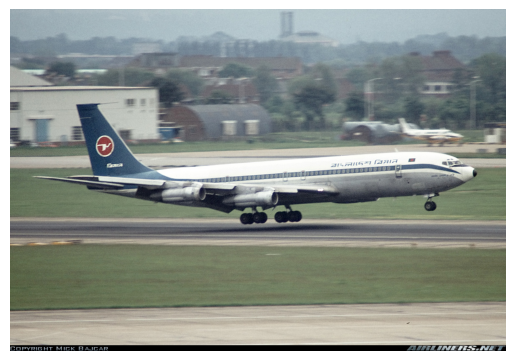


IMAGE DESCRIPTION:
tupolev sb,707,boeing 707,douglas dc-8,boeing 2707

MODEL_RESPONSE: 
A large commercial airplane with a blue tail and a red logo, possibly a Qantas Boeing 747, is taking off from an airport runway.


In [20]:
id = 1

image = filtered_test_dataset["test"][id]["image"].convert("RGB")
description = ",".join(filtered_test_dataset["test"][id]['clip_tags_ViT_L_14'])

print(f"CHAT_TEMPLATE: \n{processor.tokenizer.chat_template}")

userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"
messages = [
    {"role": "user", "content": f"<|image_1|>\n{userPrompt}"}
]

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(f"\nPROMPT: \n{prompt}")

inputs = processor(prompt, [image], return_tensors="pt").to(device)

generation_args = {
    "max_new_tokens": 512,
    "temperature": 0.0
}

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]
response = processor.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

plt.imshow(image)
plt.axis("off")
plt.show()

print(f"\nIMAGE DESCRIPTION:\n{description}")
print(f"\nMODEL_RESPONSE: \n{response}")

The base model provides a general response to the image, which can be seen in the generated caption. However, this response has several limitations when it comes to the precise identification of specific airplane types and relevant details.

# 5. Fine-tuning

## 5.1 Prepare Dataset

In [21]:
split_dataset = filtered_train_dataset["train"].train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]
test_dataset = filtered_test_dataset["test"]

columns_to_keep = ["image", "clip_tags_ViT_L_14"]

train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in columns_to_keep])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in columns_to_keep])
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in columns_to_keep])

In [22]:
train_dataset

Dataset({
    features: ['image', 'clip_tags_ViT_L_14'],
    num_rows: 108
})

In [23]:
val_dataset

Dataset({
    features: ['image', 'clip_tags_ViT_L_14'],
    num_rows: 28
})

In [42]:
test_dataset

Dataset({
    features: ['image', 'clip_tags_ViT_L_14'],
    num_rows: 161
})

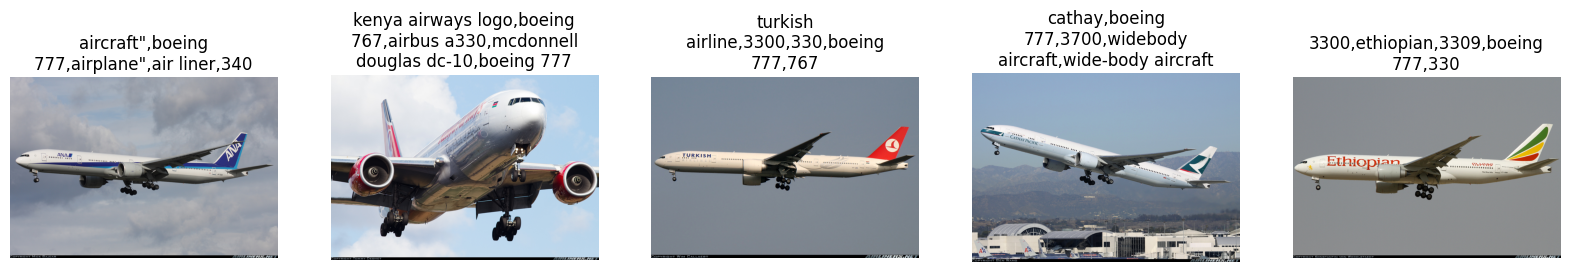

In [24]:
# Code taken from https://huggingface.co/docs/transformers/main/en/tasks/image_captioning
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(",".join(caption), 30))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

sample_images_to_visualize = [np.array(train_dataset[i]["image"]) for i in range(5)]
sample_captions = [train_dataset[i]["clip_tags_ViT_L_14"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## 5.2 Setup DataCollator

Now let's define the data collator. It handles the batching and preprocessing of input data, and it prepares the input prompts and corresponding labels, ensuring they are correctly formatted and tokenized for the model. By customizing the DataCollator, we can efficiently manage complex data structures and input-output relationships required for our multi-modal fine-tuning task. This setup is crucial for creating consistent and coherent batches during training and evaluation.

In [25]:
class DataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        example = examples[0]

        image = example["image"]

        user_prompt = "Generate a concise caption for this image, mentioning specific airplane types"
        answer = ",".join(example["clip_tags_ViT_L_14"])

        messages = [
            {"role": "user", "content": f"<|image_1|>\n{user_prompt}"}
        ]

        prompt = self.processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        answer = f"{answer}<|end|>\n<|endoftext|>"

        # Mask user_prompts for labels
        batch = self.processor(prompt, [image], return_tensors="pt")
        prompt_input_ids = batch["input_ids"]

        answer_input_ids = self.processor.tokenizer(answer, add_special_tokens=False, return_tensors="pt")["input_ids"]

        concatenated_input_ids = torch.cat([prompt_input_ids, answer_input_ids], dim=1)
        ignore_index = -100
        labels = torch.cat(
            [
                torch.tensor([ignore_index] * len(prompt_input_ids[0])).unsqueeze(0),
                answer_input_ids,
            ],
            dim=1,
        )

        batch["input_ids"] = concatenated_input_ids
        batch["labels"] = labels

        # Ensure only floating-point tensors require gradients
        for key, value in batch.items():
            if isinstance(value, torch.Tensor) and torch.is_floating_point(value):
                batch[key] = value.clone().detach().requires_grad_(True)

        return batch

In [26]:
data_collator = DataCollator(processor)

In [27]:
examples = [train_dataset[i] for i in range(5)]
collator_output = data_collator(examples)
print(collator_output.keys())

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_sizes', 'labels'])


## 5.3 Setup LoRA

Next, let's prepare the model for fine-tuning using LoRA (Low-Rank Adaptation). LoRA is a technique used to efficiently fine-tune transformer models by introducing trainable low-rank matrices into the layers of the model. This approach reduces the number of parameters that need to be updated during training, making the process more memory-efficient and faster.

We will apply LoRA specifically to the attention mechanisms and feed-forward operations of the model. To identify the relevant target modules, we will use the command `model.state_dict().keys()` to inspect the names of the modules within the model. The modules related to attention mechanisms and feed-forward operations are then specified in the LoRA configuration, ensuring that the fine-tuning process is focused on these components.

In [28]:
model.resize_token_embeddings(len(processor.tokenizer))
model.gradient_checkpointing_enable()

In [29]:
model.state_dict().keys()

odict_keys(['model.embed_tokens.weight', 'model.vision_embed_tokens.glb_GN', 'model.vision_embed_tokens.sub_GN', 'model.vision_embed_tokens.wte.weight', 'model.vision_embed_tokens.img_processor.vision_model.embeddings.class_embedding', 'model.vision_embed_tokens.img_processor.vision_model.embeddings.patch_embedding.weight', 'model.vision_embed_tokens.img_processor.vision_model.embeddings.position_embedding.weight', 'model.vision_embed_tokens.img_processor.vision_model.pre_layrnorm.weight', 'model.vision_embed_tokens.img_processor.vision_model.pre_layrnorm.bias', 'model.vision_embed_tokens.img_processor.vision_model.encoder.layers.0.self_attn.k_proj.weight', 'model.vision_embed_tokens.img_processor.vision_model.encoder.layers.0.self_attn.k_proj.bias', 'model.vision_embed_tokens.img_processor.vision_model.encoder.layers.0.self_attn.v_proj.weight', 'model.vision_embed_tokens.img_processor.vision_model.encoder.layers.0.self_attn.v_proj.bias', 'model.vision_embed_tokens.img_processor.vision

In [30]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj.weight",
        "self_attn.k_proj.weight",
        "self_attn.v_proj.weight",
        "self_attn.qkv_proj.weight",
        "self_attn.out_proj.weight",
        "mlp.gate_up_proj",
        "mlp.down_proj"
    ],
    lora_dropout=0.06,
    bias="none",
    task_type="CAUSAL_LM",
    use_dora=False
)

peft_model = get_peft_model(model, lora_config)

train_dataset.start_iteration = 0

In [31]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 15728640 || all params: 4260733952 || trainable%: 0.3691533002809747


## 5.4 Training

In [32]:
training_args = transformers.TrainingArguments(
    num_train_epochs=4,                          # Number of training epochs
    per_device_train_batch_size=batch_size,      # Batch size for training
    per_device_eval_batch_size=batch_size,       # Batch size for evaluation
    gradient_accumulation_steps=6,               # Number of steps to accumulate gradients before updating
    gradient_checkpointing=True,                 # Enable gradient checkpointing to save memory
    do_eval=True,                                # Perform evaluation during training
    save_total_limit=2,                          # Limit the total number of saved checkpoints
    evaluation_strategy="steps",                 # Evaluation strategy to use (here, at each specified number of steps)
    save_strategy="steps",                       # Save checkpoints at each specified number of steps
    save_steps=10,                               # Number of steps between each checkpoint save
    eval_steps=10,                               # Number of steps between each evaluation
    max_grad_norm=1,                             # Maximum gradient norm for clipping
    warmup_ratio=0.1,                            # Warmup ratio for learning rate schedule
    weight_decay=0.01,                           # Regularization technique to prevent overfitting
    # fp16=True,                                 # Enable mixed precision training with fp16 (enable it if Ampere architecture is unavailable)
    bf16=True,                                   # Enable mixed precision training with bf16
    logging_steps=10,                            # Number of steps between each log
    output_dir="outputs",                        # Directory to save the model outputs and checkpoints
    optim="adamw_torch",                         # Optimizer to use (AdamW with PyTorch)
    learning_rate=1e-4,                          # Learning rate for the optimizer
    lr_scheduler_type="constant",                # Learning rate scheduler type
    load_best_model_at_end=True,                 # Load the best model found during training at the end
    metric_for_best_model="rouge",               # Metric used to determine the best model
    greater_is_better=True,                      # Indicates if a higher metric score is better
    push_to_hub=False,                           # Whether to push the model to Hugging Face Hub
    run_name="phi-3-vision-finetuning",          # Name of the run for experiment tracking
    report_to="wandb"                            # For experiment tracking (login to Weights & Biases needed)
)


In [33]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)

    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    rouge_scores = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
    rouge1_score = rouge_scores["rouge1"]
    return {"rouge": rouge1_score}

In [34]:
predictions = ["A large commercial airplane with a blue tail and a red logo, possibly a Qantas Boeing 747, is taking off from an airport runway."]
references = ["tupolev sb,707,boeing 707,douglas dc-8,boeing 2707"]

rouge_score = rouge.compute(predictions=predictions, references=references)
print(rouge_score)

{'rouge1': 0.058823529411764705, 'rouge2': 0.0, 'rougeL': 0.058823529411764705, 'rougeLsum': 0.058823529411764705}


In [35]:
class CustomTrainer(transformers.Trainer):
    def get_train_dataloader(self):
        # Ensure the DataLoader uses your custom DataCollator
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

    def get_eval_dataloader(self, eval_dataset=None):
        # Ensure the DataLoader uses your custom DataCollator for evaluation
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        return DataLoader(
            eval_dataset,
            batch_size=self.args.eval_batch_size,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        loss = outputs.loss if isinstance(outputs, dict) else outputs[0]
        return (loss, outputs) if return_outputs else loss

# Ensure the model is in training mode
peft_model.train()

trainer = CustomTrainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[early_stopping]
)

peft_model.config.use_cache = False

In [36]:
trainer.train()

Step,Training Loss,Validation Loss,Rouge
10,2.948700,2.165012,0.009176
20,1.845700,1.670141,0.012313
30,1.464100,1.275338,0.012986
40,1.069000,1.099998,0.014323
50,0.930800,0.946274,0.016099
60,0.702800,0.899729,0.015994
70,0.634100,0.893305,0.016366


TrainOutput(global_step=72, training_loss=1.3471607913573582, metrics={'train_runtime': 527.5741, 'train_samples_per_second': 0.819, 'train_steps_per_second': 0.136, 'total_flos': 2.093325015728947e+16, 'train_loss': 1.3471607913573582, 'epoch': 4.0})

In [37]:
trainer.save_model(model_dir)
processor.save_pretrained(model_dir)

[]

# 6. Inference with Finetuned Model

In [38]:
def load_with_peft_adapter(base_model_id, model_path, device="cpu", dtype=torch.bfloat16):
    """
        load model via Huggingface AutoModelForCausalLM and AutoProcessor
    """
    torch.set_default_device(device)

    with torch.device(device):

        processor = transformers.AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

        model = transformers.AutoModelForCausalLM.from_pretrained(
            base_model_id,
            device_map=device,
            torch_dtype=dtype,
            trust_remote_code=True
        ).eval()

        model.resize_token_embeddings(len(processor.tokenizer))

        finetuned_model = PeftModel.from_pretrained(
            model,
            model_path
        ).eval()
        finetuned_model.to(device)
        finetuned_model.config.use_cache = True

        return finetuned_model, processor

finetuned_model, processor = load_with_peft_adapter(base_model_id, model_dir, device="cuda", dtype=dtype)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


PROMPT: 
<|user|>
<|image_1|>
Generate a concise caption for this image, mentioning specific airplane types<|end|>
<|assistant|>



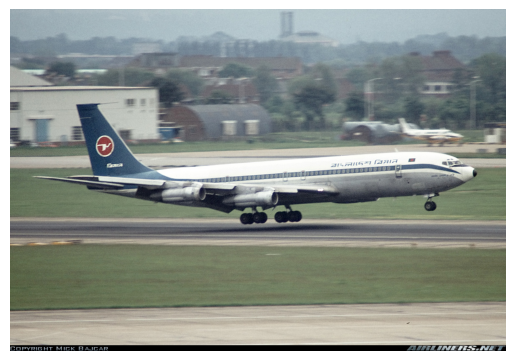

MODEL RESPONSE: tupolev sb,boeing 737 next generation,boeing 737,tupolev sb,boeing 737 

EXPECTED RESPONSE: tupolev sb,707,boeing 707,douglas dc-8,boeing 2707


In [39]:
def inference_with_finetuned_model(finetuned_model, processor, tokenizer, image, device="cuda", temperature = 0.0):
  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"

  prompt = f"<|user|>\n<|image_1|>\n{userPrompt}<|end|>\n<|assistant|>\n"

  print(f"\nPROMPT: \n{prompt}")

  plt.imshow(image)
  plt.axis("off")
  plt.show()

  inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

  generation_args = {
      "max_new_tokens": 128,
      "temperature": 0.0
  }

  with torch.no_grad():
    generate_ids = finetuned_model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]

  decoded_output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  response = decoded_output[0]

  return response


id = 1

image = filtered_test_dataset["test"][id]["image"].convert("RGB")
description = ",".join(filtered_test_dataset["test"][id]["clip_tags_ViT_L_14"])

response = inference_with_finetuned_model(finetuned_model, processor, processor.tokenizer, image, device)
print(f"MODEL RESPONSE: {response}")
print(f"EXPECTED RESPONSE: {description}")

# 7. Testing

In [55]:
def inference_with_base_model(id, dataset):
  image = dataset[id]["image"].convert("RGB")

  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"
  messages = [
      {"role": "user", "content": f"<|image_1|>\n{userPrompt}"}
  ]

  prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  inputs = processor(prompt, [image], return_tensors="pt").to(device)

  generation_args = {
      "max_new_tokens": 512,
      "temperature": 0.0
  }

  generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]
  response = processor.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

  return response


def inference_with_finetuned_model(id, dataset, finetuned_model, processor, tokenizer, device="cuda", temperature = 0.0):
  image = dataset[id]["image"].convert("RGB")

  userPrompt = "Generate a concise caption for this image, mentioning specific airplane types"

  prompt = f"<|user|>\n<|image_1|>\n{userPrompt}<|end|>\n<|assistant|>\n"

  inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

  generation_args = {
      "max_new_tokens": 128,
      "temperature": 0.0
  }

  with torch.no_grad():
    generate_ids = finetuned_model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

  generate_ids = generate_ids[:, inputs["input_ids"].shape[1]:]

  decoded_output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
  response = decoded_output[0]

  return response

In [66]:
images_to_visualize = [np.array(test_dataset[i]["image"]) for i in range(5)] #len(test_dataset)
expected_captions = [test_dataset[i]["clip_tags_ViT_L_14"] for i in range(5)]
base_model_captions = [inference_with_base_model(i, test_dataset) for i in range(5)]
finetuned_model_captions = [inference_with_finetuned_model(i, test_dataset, finetuned_model, processor, processor.tokenizer) for i in range(5)]

In [71]:
def plot_images(images, expected_captions, model_captions, model_captions_color="red"):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)

        expected_caption = expected_captions[i]
        expected_caption = "\n".join(wrap(",".join(expected_caption), 30))

        model_caption = model_captions[i]
        model_caption = "\n".join(wrap(model_caption, 30))

        plt.title(expected_caption, color="green", fontsize=12)
        plt.xlabel(model_caption, color=model_captions_color, fontsize=10, labelpad=20)

        plt.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

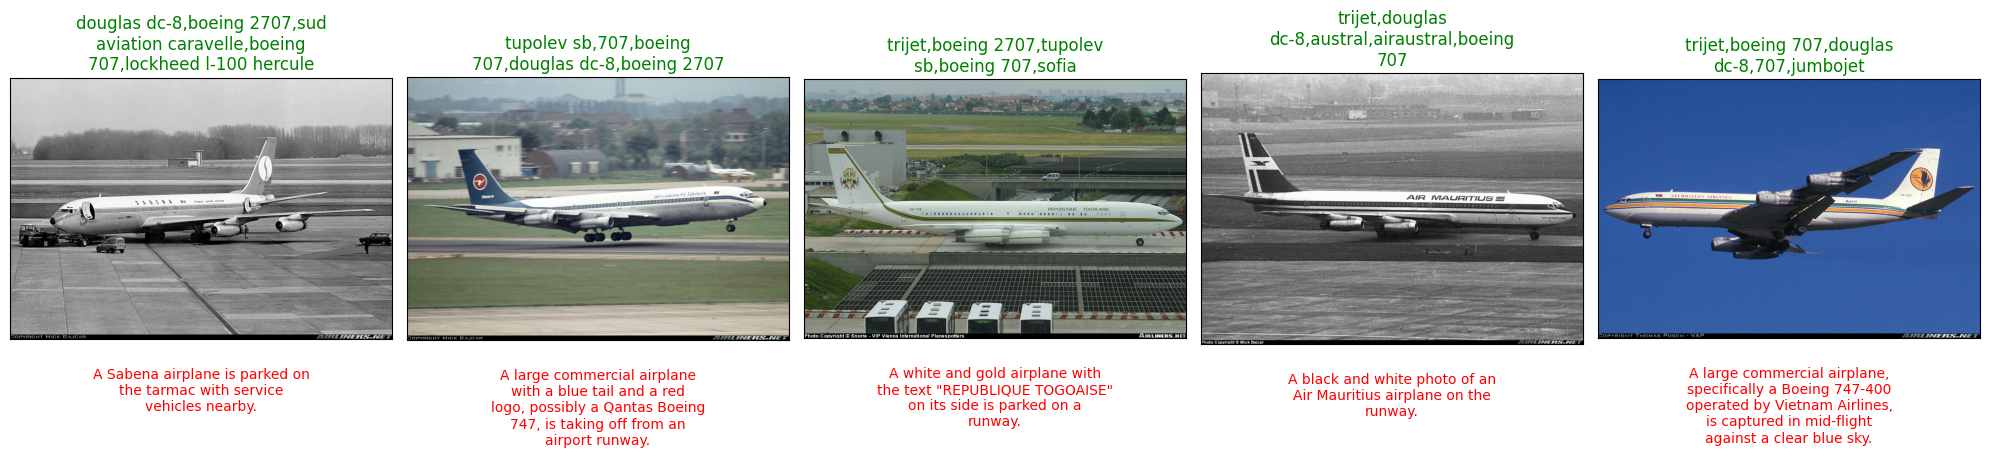

In [67]:
plot_images(images_to_visualize, expected_captions, base_model_captions)

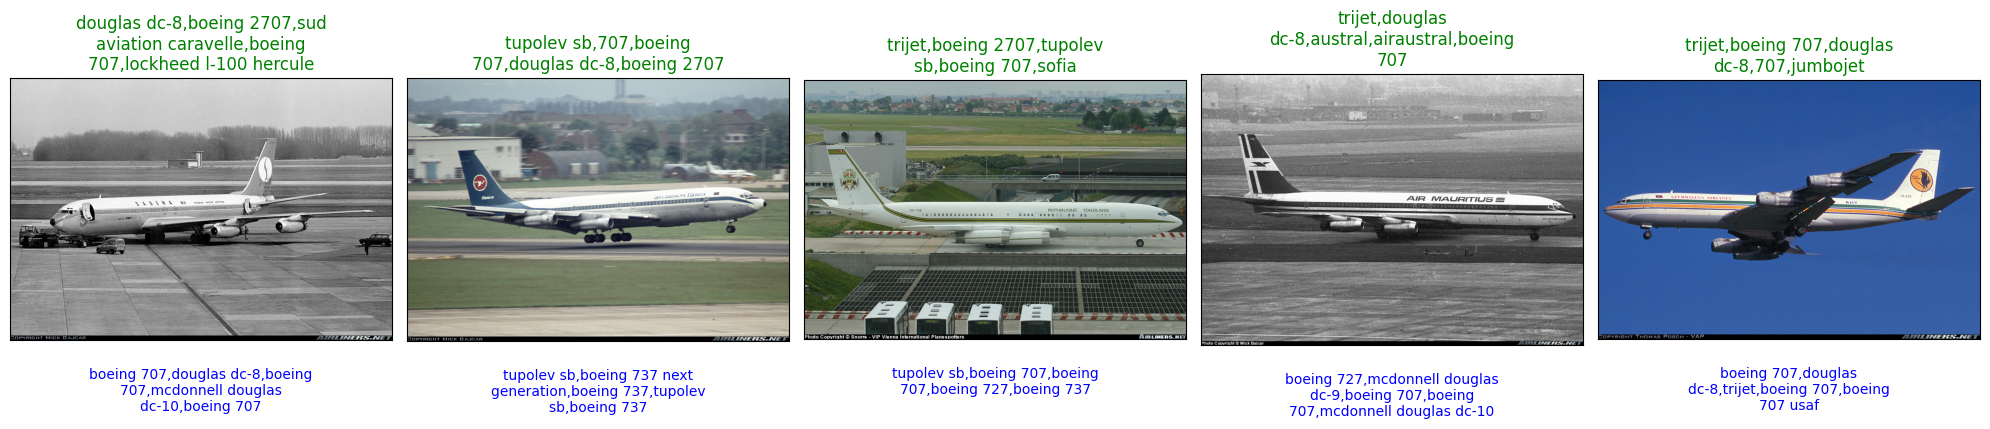

In [72]:
plot_images(images_to_visualize, expected_captions, finetuned_model_captions, "blue")

In [68]:
expected_captions_formatted = [",".join(c) for c in expected_captions]
base_rouge_score = rouge.compute(predictions=expected_captions_formatted, references=base_model_captions)
fintuned_rouge_score = rouge.compute(predictions=expected_captions_formatted, references=finetuned_model_captions)

print(base_rouge_score)
print(fintuned_rouge_score)

{'rouge1': 0.024667931688804552, 'rouge2': 0.0, 'rougeL': 0.024667931688804552, 'rougeLsum': 0.024667931688804552}
{'rouge1': 0.492822966507177, 'rouge2': 0.3166470588235294, 'rougeL': 0.4495481127060074, 'rougeLsum': 0.4495481127060074}
